In [179]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os

import sys
sys.path.append("../ift6758/")
from utils.data_processing import parse_input

DATA_PATH = "../new_data/Train/"
X_ll, Y_all = parse_input(DATA_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
Y_all.shape

(9500, 8)

In [168]:
relation_data = pd.read_csv(os.path.join(DATA_PATH, "Relation", "Relation.csv"))
print(f"relation_data.shape = {relation_data.shape}, relation_data.columns = {relation_data.columns}")

relation_data.shape = (1671353, 3), relation_data.columns = Index(['Unnamed: 0', 'userid', 'like_id'], dtype='object')


In [169]:
print(f"unique user-ids: in profile =  {Y_all['userid'].nunique()}, "
      f"in relation = {relation_data['userid'].nunique()}")
print(f"for relation_data, unique like_ids = {relation_data['like_id'].nunique()}")


unique user-ids: in profile =  9500, in relation = 9500
for relation_data, unique like_ids = 536204


In [170]:
relation_data_merged = pd.merge(relation_data, Y_all, on='userid')
print(f"num relation rows = pre-merge:{relation_data.shape[0]}, post-merge:{relation_data_merged.shape[0]}")

num relation rows = pre-merge:1671353, post-merge:1671353


In [171]:
relation_data_merged.head()

,Unnamed: 0,userid,like_id,age,gender,ope,con,ext,agr,neu
0,0,c6a9a43058c8cc8398ca6e97324c0fae,8628204013,35-49,0.0,3.8,3.1,2.75,3.85,3.65
1,1,c6a9a43058c8cc8398ca6e97324c0fae,19040608370,35-49,0.0,3.8,3.1,2.75,3.85,3.65
2,2,c6a9a43058c8cc8398ca6e97324c0fae,24054583527,35-49,0.0,3.8,3.1,2.75,3.85,3.65
3,3,c6a9a43058c8cc8398ca6e97324c0fae,26726417043,35-49,0.0,3.8,3.1,2.75,3.85,3.65
4,4,c6a9a43058c8cc8398ca6e97324c0fae,31796936730,35-49,0.0,3.8,3.1,2.75,3.85,3.65


In [172]:
relation_data_gender = relation_data_merged[['like_id', 'gender']].groupby('like_id').mean()
relation_data_gender.head()

,gender
like_id,
2215974432,0.333333
2219089314,0.709677
2219808235,0.846154
2231777543,0.512821
2232594215,1.000000


In [173]:
relation_data_age = relation_data_merged[['like_id', 'age']] #.groupby('like_id')
relation_data_age.head()

,like_id,age
0,8628204013,35-49
1,19040608370,35-49
2,24054583527,35-49
3,26726417043,35-49
4,31796936730,35-49


In [174]:
# verify that LikeIds are same in Train and PublicTest datasets
relational_data_ptest = pd.read_csv("../new_data/Public_Test/Relation/Relation.csv")
print(f"unique LikeIds in relational_data_ptest = {relational_data_ptest['like_id'].nunique()}")
relational_merge_train_ptest = pd.merge(relational_data_ptest['like_id'], relational_data_ptest['like_id'], on="like_id")
print(f"unique LikeIds after merge with train-set = {relational_merge_train_ptest['like_id'].nunique()}")


unique LikeIds in relational_data_ptest = 37073
unique LikeIds after merge with train-set = 37073


In [187]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from models.final_estimator import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from utils.data_processing import parse_input

class RelationalNaiveAgeClassifier(BaseEstimator):
    def __init__(self, normalize=False):
        super().__init__()
        self.normalize=normalize
        self.classes = ["xx-24", "25-34", "35-49", "50-xx"]
        # self.relational_df = relational_df
    
    def fit(self, like_age):
        self.like_ages_counts = like_age.groupby(['like_id', 'age']).size().unstack(fill_value=0)
        
    def predict(self, user_like):
        user_like_ages_counts = pd.merge(user_like, self.like_ages_counts, on='like_id', how='left')
        if self.normalize:
            norm_ages_counts = user_like_ages_counts[self.classes].div(user_like_ages_counts[self.classes].sum(axis=1), axis=0)
            user_like_ages_counts[self.classes] = norm_ages_counts
        userid_grouped_df = user_like_ages_counts.groupby('userid').mean().reset_index()
        userid_grouped_df['argmax_age'] = userid_grouped_df[self.classes].idxmax(axis=1)
        return userid_grouped_df[['userid', 'argmax_age']].fillna("xx-24")
        

class AgeClassifier(BaseEstimator):
    def __init__(self, n_estimators=40):
        super().__init__()
        self.model = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=n_estimators))
    
    def fit(self, X, y):
#         X = X['text']
        self.model.fit(X, y)

    def predict(self, X):
#         X = X['text']
        return self.model.predict(X)

def eval_model(model_cls, model_params, train_data, test_data):
    model = model_cls(**model_params)

    user_like_age_train, user_age_train = train_data[0], train_data[1]
    user_like_train = user_like_age_train[['userid', 'like_id']]
    user_like_age_test, user_age_test = test_data[0], test_data[1]
    user_like_test = user_like_age_test[['userid', 'like_id']]
    # fit model
    model.fit(user_like_age_train)

    # evaluate train perf
    train_pred = model.predict(user_like_train)
    print(f"train_y.shape = {user_age_train.shape}, train_pred.shape = {train_pred.shape}")
    train_y_pred_merge = pd.merge(user_age_train, train_pred, on='userid')
    train_acc = accuracy_score(train_y_pred_merge['age'], train_y_pred_merge['argmax_age'])

    # test performance
    test_pred = model.predict(user_like_test)
    print(f"test_y.size = {user_age_test.size}, test_pred.size = {test_pred.size}")
    test_y_pred_merge = pd.merge(user_age_test, test_pred, on='userid')
    test_acc = accuracy_score(test_y_pred_merge['age'], test_y_pred_merge['argmax_age'])
    
    print(f"train_acc = {train_acc}; test_acc = {test_acc}\n")
    return {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc
    }


relation_data_age sample = 
       like_id    age
0   8628204013  35-49
1  19040608370  35-49
2  24054583527  35-49
3  26726417043  35-49
4  31796936730  35-49
 num_rows = 1671353
in rows = 334, out rows = 334
  argmax_age  userid
0      25-34      11
1      35-49       1
2      50-xx       2
3      xx-24     320


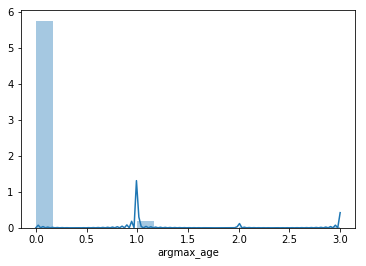

In [176]:
clf = RelationalNaiveAgeClassifier(normalize=True)
print(f"relation_data_age sample = \n{relation_data_age[:5]}\n num_rows = {relation_data_age.shape[0]}")
clf.fit(relation_data_age)
clf.like_ages_counts.head()

ptest_result = clf.predict(relational_data_ptest)
print(f"in rows = {relational_data_ptest['userid'].nunique()}, out rows = {ptest_result.shape[0]}")
print(ptest_result.groupby('argmax_age').count().reset_index())

import seaborn as sns
label_map = {'xx-24':0, '25-34':1, '35-49':2, '50-xx':3}
sns.distplot(ptest_result['argmax_age'].apply(lambda x: label_map[x]))

In [177]:
Y_all.shape

(9500, 8)

In [186]:
from tqdm import tqdm

# print(X_all.keys())
# print(Y_all.keys())

X_relation = relation_data
y_age = Y_all[['userid', 'age']]
user_like_age = pd.merge(X_relation, y_age, on='userid')
print(f'y_age.shape = {y_age.shape}, like_age.shape = {like_age.shape}\n')
print(f'y_age.columns = {y_age.columns}, like_age.columns = {like_age.columns}\n')

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

methods = [RelationalNaiveAgeClassifier]
method_params = [{'normalize': True}]

print(pd.DataFrame(np.array(y_age), columns=['userid', 'age'])[:3])

method_stats = {}
for train_index, test_index in tqdm(kf.split(y_age)):
    y_train = pd.DataFrame(np.array(y_age)[train_index], columns=['userid', 'age'])
    y_test = pd.DataFrame(np.array(y_age)[test_index], columns=['userid', 'age'])
    X_train = user_like_age[user_like_age.userid.isin(y_train.userid)]
    X_test = user_like_age[user_like_age.userid.isin(y_test.userid)]

    train_data = (X_train, y_train)
    test_data = (X_test, y_test)
    for m, m_params in zip(methods, method_params):
        ret = eval_model(m, m_params, train_data, test_data)
        m_name = f"{m.__name__}_{m_params['normalize']}"
        if m_name not in method_stats:
            method_stats[m_name] = []
        method_stats[m_name].append([ret['train_acc'], ret['test_acc']])
for m_name, stats in method_stats.items():
    print(f"stats = {stats}")
    stats = np.array(stats)
    mean = np.mean(stats, axis=0)
    std = np.std(stats, axis=0)
    print(f'Method: {m_name} Train Acc {mean[0]}+-{std[0]} Test Acc {mean[1]}+-{std[1]}')

0it [00:00, ?it/s]

y_age.shape = (9500, 2), like_age.shape = (1671353, 4)

y_age.columns = Index(['userid', 'age'], dtype='object'), like_age.columns = Index(['Unnamed: 0', 'userid', 'like_id', 'age'], dtype='object')

                             userid    age
0  7267f43c71fcf53f4580fd3cd808bd48  25-34
1  e1cdac10d136e76e064e4860007d786d  xx-24
2  ea4b8b534a35f59713f61f29b8725d09  25-34
*** (7600, 2), (1900, 2) ***
train_y.size = 15200, train_pred.size = 15200


1it [00:02,  2.28s/it]

test_y.size = 3800, test_pred.size = 3800
train_acc = 0.905921052631579; test_acc = 0.49842105263157893

*** (7600, 2), (1900, 2) ***
train_y.size = 15200, train_pred.size = 15200


2it [00:04,  2.19s/it]

test_y.size = 3800, test_pred.size = 3800
train_acc = 0.9178947368421052; test_acc = 0.61

*** (7600, 2), (1900, 2) ***
train_y.size = 15200, train_pred.size = 15200


3it [00:06,  2.16s/it]

test_y.size = 3800, test_pred.size = 3800
train_acc = 0.9176315789473685; test_acc = 0.58

*** (7600, 2), (1900, 2) ***
train_y.size = 15200, train_pred.size = 15200


4it [00:08,  2.15s/it]

test_y.size = 3800, test_pred.size = 3800
train_acc = 0.9153947368421053; test_acc = 0.6042105263157894

*** (7600, 2), (1900, 2) ***
train_y.size = 15200, train_pred.size = 15200


5it [00:10,  2.06s/it]

test_y.size = 3800, test_pred.size = 3800
train_acc = 0.9422368421052632; test_acc = 0.7363157894736843

stats = [[0.905921052631579, 0.49842105263157893], [0.9178947368421052, 0.61], [0.9176315789473685, 0.58], [0.9153947368421053, 0.6042105263157894], [0.9422368421052632, 0.7363157894736843]]
Method: RelationalNaiveAgeClassifier_True Train Acc 0.9198157894736841+-0.012031410875098117 Test Acc 0.6057894736842104+-0.07648583595995456


7600 1900
7600 1900
7600 1900
7600 1900
7600 1900
